In [4]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K

from MD_AE_model import *

import h5py
import numpy as np
import matplotlib.pyplot as plt
from contextlib import redirect_stdout

import time
import configparser
config = configparser.ConfigParser()
config.read('__system.ini')
system_info = config['system_info']

#============================== CCHANGE THESE VALUES ======================
# data
data_file = '../Data/PIV/PIV4_downsampled_by8.h5'
Ntrain = 1800 # snapshots for training
Ntest = 900 # sanpshots for testing

# path
results_folder = 'MD_10__2022_05_10__14_20_22-linear'
folder = system_info['save_location'] + '/' + results_folder + '/'

## ae configuration
filename = folder + 'Model_param.h5'
file = h5py.File(filename,'r')
lmb = file.get('lmb')[()]#1e-05 #regulariser
drop_rate = file.get('drop_rate')[()]
features_layers = np.array(file.get('features_layers')).tolist()
latent_dim = file.get('latent_dim')[()]
act_fct = file.get('act_fct')[()].decode()
resize_meth = file.get('resize_meth')[()].decode()
filter_window= np.array(file.get('filter_window')).tolist()
batch_norm = file.get('batch_norm')[()]
REMOVE_MEAN = file.get('REMOVE_MEAN')[()]
file.close()
print('REMOVE_MEAN',REMOVE_MEAN)

#================================= IMPORT DATA ==========================================================
Nz = 24 # grid size
Ny = 21
Nu = 2
Nt = 2732 # number of snapshots available
D = 196.5 # mm diameter of bluff body
U_inf = 15 # m/s freestream velocity
f_piv = 720.0 # Hz PIV sampling frequency  
dt = 1.0/f_piv 
Nx = [Ny,Nz]

filename = folder + 'results.h5'
file = h5py.File(filename,'r')
u_train = np.array(file.get('u_train')) # fluctuating velocity if REMOVE_MEAN is true
y_train = np.array(file.get('y_train'))
u_test = np.array(file.get('u_test')) # fluctuating velocity if REMOVE_MEAN is true
y_test = np.array(file.get('y_test'))
u_avg = np.array(file.get('u_avg'))
latent_train = np.array(file.get('latent_train'))
latent_test = np.array(file.get('latent_test'))
modes_train = np.array(file.get('modes_train'))
modes_test = np.array(file.get('modes_test')) #(modes,snapshots,Nx,Ny,Nu)
file.close()

print("y_test.shape",y_test.shape)

REMOVE_MEAN True
y_test.shape (600, 21, 24, 2)


In [ ]:
## get models
md_ae = MD_Autoencoder(Nx=Nx,Nu=Nu,features_layers=features_layers,latent_dim=latent_dim,filter_window=filter_window,act_fct=act_fct,batch_norm=batch_norm,drop_rate=drop_rate,lmb=lmb)

## restore models
filename = folder + 'md_ae_model.h5'
md_ae.compile(optimizer=Adam(learning_rate=0.001),loss='mse')
md_ae.evaluate(u_test,u_test)
md_ae.load_weights(filename)
md_ae.evaluate(u_test,u_test)

encoder = md_ae.encoder
decoders = []
for name in md_ae.name_decoder:
    decoders.append(md_ae.get_layer(name))

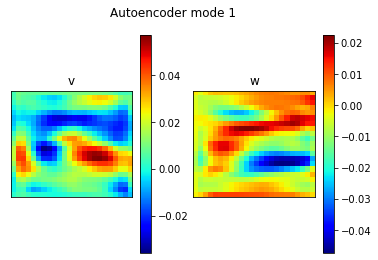

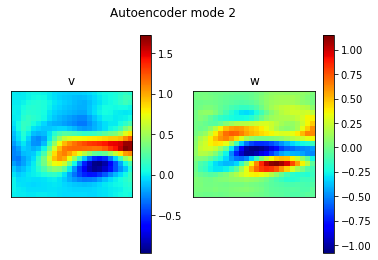

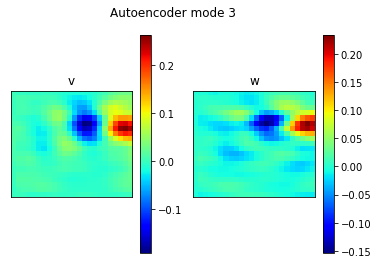

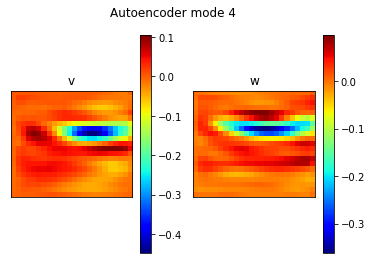

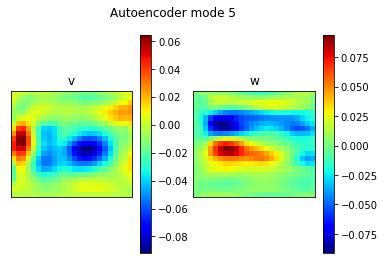

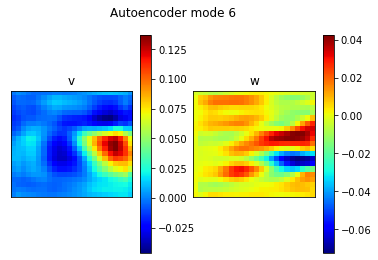

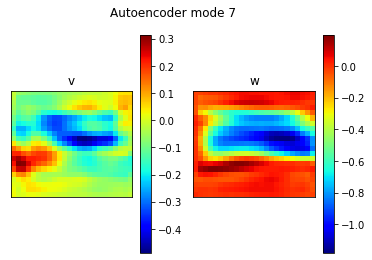

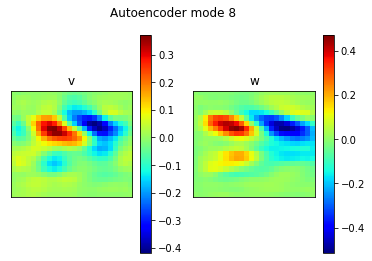

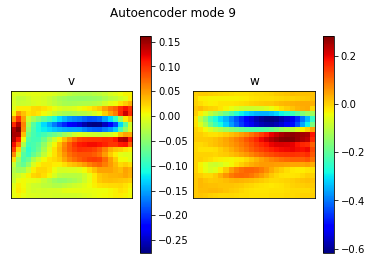

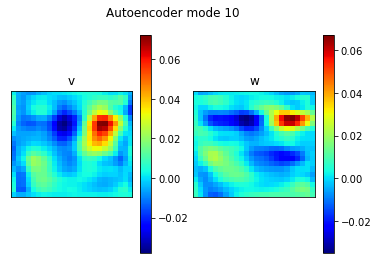

In [6]:
import myplot

# modes_test = []
# for i in range(0,10):
#     z = latent_test[:,i]
#     z = np.reshape(z,(-1,1))
#     modes_test.append(decoders[i].predict(z))
# modes_test = np.array(modes_test)
myplot.plot_ae_modes(modes_test,range(10),snapshot=0)

### Plot results

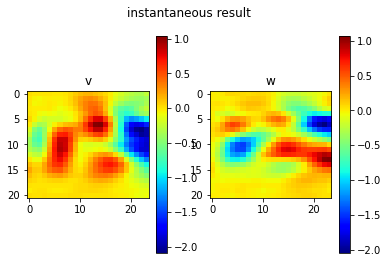

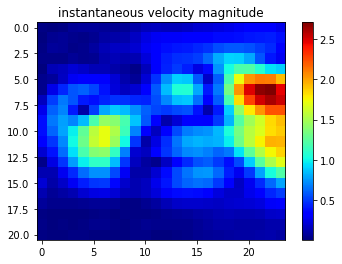

In [7]:
## instantaneous results
time = 500 # which snapshot?
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig1 = ax1.imshow(y_test[time,:,:,0],'jet')
ax1.set_title('v')
fig.colorbar(fig1,ax=ax1)

fig2 = ax2.imshow(y_test[time,:,:,1],'jet')
ax2.set_title('w')
fig.colorbar(fig2,ax=ax2)
plt.suptitle("instantaneous result")
plt.show()

V_test = ((y_test[:,:,:,0]**2)+(y_test[:,:,:,1]**2))**(0.5)
fig = plt.figure()
plt.imshow(V_test[time,:,:],'jet')
plt.colorbar()
plt.title('instantaneous velocity magnitude')
plt.show()

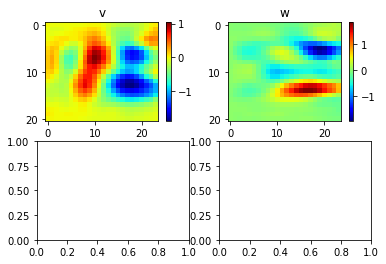

In [8]:
time = 20 # which snapshot?
fig, ax = plt.subplots(2,2)
fig1 = ax[0,0].imshow(y_test[time,:,:,0],'jet')
ax[0,0].set_title('v')
fig.colorbar(fig1,ax=ax[0,0])
fig2 = ax[0,1].imshow(y_test[time,:,:,1],'jet')
ax[0,1].set_title('w')
fig.colorbar(fig2,ax=ax[0,1])

(600, 10)


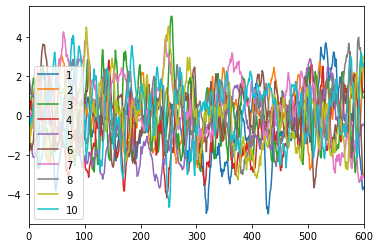

In [9]:
## latent space line plot
print(latent_test.shape)
plt.figure()
for z in range(latent_dim):
    plt.plot(latent_test[:,z],label=str(z+1))
plt.xlim([0,600])
plt.legend()
plt.show()

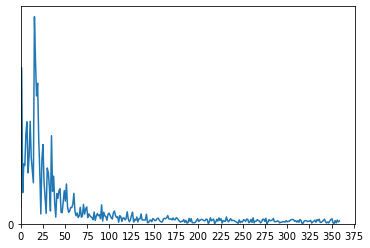

In [10]:
# fft of latent space signal
signal_in = latent_test[:,1] # which one
signal_fft = np.fft.fft(signal_in)
signal_fft_power = np.abs(signal_fft)/signal_in.size
signal_freq = np.fft.fftfreq(signal_in.size)
signal_freq = signal_freq/dt
# print(signal_freq.size/2)
plt.figure()
plt.plot(signal_freq[:int(signal_freq.size/2)],signal_fft_power[:int(signal_freq.size/2)])
plt.ylim(bottom=0)
plt.yticks([0])
plt.xlim(left=0)
loc,label = plt.xticks()
loc = np.r_[0:max(loc):25]
plt.xticks(loc)
plt.show()

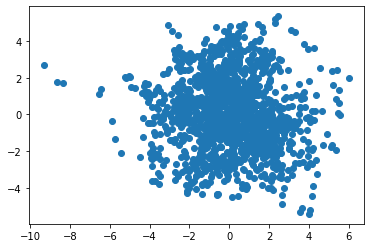

In [11]:
plt.figure()
plt.scatter(latent_train[:,0],latent_train[:,3])
plt.show()

Text(0.5, 0.98, 'u and v autoencoder modes')

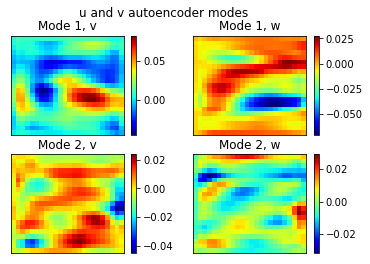

In [12]:
## plot time-averaged autoencoder mode
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

mode1_1 = ax1.imshow(np.mean(modes_test,axis=1)[0,:,:,0],'jet')
ax1.set_title("Mode 1, v")
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(mode1_1,ax=ax1)

mode1_2 = ax2.imshow(np.mean(modes_test,axis=1)[0,:,:,1],'jet')
ax2.set_title("Mode 1, w")
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(mode1_2,ax=ax2)

mode2_1 = ax3.imshow(np.mean(modes_test,axis=1)[1,:,:,0],'jet')
ax3.set_title("Mode 2, v")
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(mode2_1,ax=ax3)

mode2_2 = ax4.imshow(np.mean(modes_test,axis=1)[1,:,:,1],'jet')
ax4.set_title("Mode 2, w")
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(mode2_2,ax=ax4)
plt.suptitle("u and v autoencoder modes")

In [13]:
print(modes_test.shape)
modes_test_mean = np.mean(modes_test,axis=1)
print(modes_test_mean.shape)
mode_test = np.transpose(modes_test,[1,0,2,3,4])
print(mode_test.shape)
mode_test = mode_test-modes_test_mean
print(mode_test.shape)
# mode_test = np.transpose(mode_test,[1,0,2,3,4])

(10, 600, 21, 24, 2)
(10, 21, 24, 2)
(600, 10, 21, 24, 2)
(600, 10, 21, 24, 2)


(10, 604800)


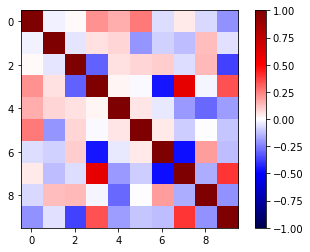

In [14]:
flatmodes = np.reshape(modes_test[:,:,:,:,:],[latent_dim,-1])
print(flatmodes.shape)
cov = np.corrcoef(latent_test.T)
# cov = np.corrcoef(flatmodes)
# print(cov)
plt.figure()
plt.imshow(cov,cmap='seismic',vmin=-1,vmax=1)
plt.colorbar()
plt.show()

Text(0.5, 0.98, 'instantaneous u and v autoencoder modes, remove mean')

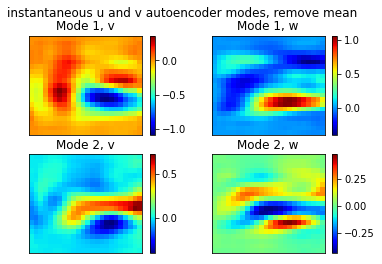

In [15]:
## plot instantaneous autoencoder modes

# test_mean = np.mean(u_test,0)
# # # test_mean = np.zeros_like(test_mean)
# print(test_mean.shape)
# mode_test = np.transpose(modes_test,[1,0,2,3,4])
# print(mode_test[:,0,:,:,:].shape)
# mode_test[:,0,:,:,:] = mode_test[:,0,:,:,:]-test_mean
# mode_test[:,1,:,:,:] = mode_test[:,1,:,:,:]-test_mean
# mode_test = np.transpose(mode_test,[1,0,2,3,4])
# print(mode_test.shape)

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

mode1_1 = ax1.imshow(mode_test[time,0,:,:,0],'jet')
ax1.set_title("Mode 1, v")
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(mode1_1,ax=ax1)

mode1_2 = ax2.imshow(mode_test[time,0,:,:,1],'jet')
ax2.set_title("Mode 1, w")
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(mode1_2,ax=ax2)

mode2_1 = ax3.imshow(mode_test[time,1,:,:,0],'jet')
ax3.set_title("Mode 2, v")
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(mode2_1,ax=ax3)

mode2_2 = ax4.imshow(mode_test[time,1,:,:,1],'jet')
ax4.set_title("Mode 2, w")
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(mode2_2,ax=ax4)
plt.suptitle("instantaneous u and v autoencoder modes, remove mean")

### Ranking

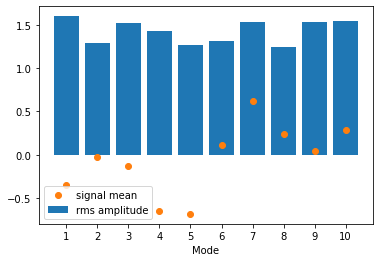

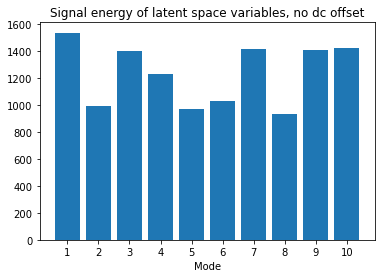

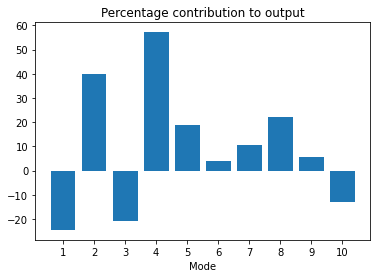

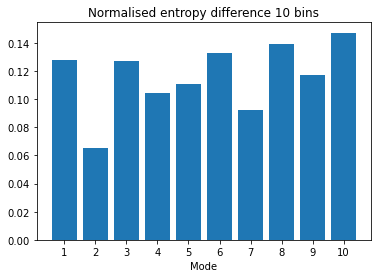

In [16]:
import autoencoder_modes_selection as ranking
SAVE_FIG = False

#========================= RMS amplitude of latent variable =====================
amp_rms,m = ranking.rms_amplitude(latent_test)
plt.figure()
plt.bar(np.arange(latent_dim)+1,amp_rms,label='rms amplitude',zorder=1)
plt.scatter(np.arange(latent_dim)+1,m,label='signal mean',zorder=2)
plt.xticks(np.arange(latent_dim)+1)
plt.legend()
plt.xlabel("Mode")
if SAVE_FIG:
    figname = folder + 'ranking_rms.png'
    plt.savefig(figname)
else:
    plt.show()

#============================ energy spectrum of signal ==========================
signal_energy = ranking.energy_freq(latent_test,remove_mean=True)
fig2 = plt.figure()
plt.bar(np.arange(latent_dim)+1,signal_energy)
plt.xticks(np.arange(latent_dim)+1)
plt.xlabel("Mode")
# plt.title("Signal energy of latent space variables")
plt.title("Signal energy of latent space variables, no dc offset")
if SAVE_FIG:
    figname = folder + 'ranking_energy.png'
    plt.savefig(figname)
else:
    plt.show()

#============================ mse loss ============================================
per_mode = ranking.percent_output(modes_test,y_test)
fig3 = plt.figure()
plt.bar(np.arange(latent_dim)+1,per_mode*100)
plt.xticks(np.arange(latent_dim)+1)
plt.xlabel("Mode")
plt.title("Percentage contribution to output")
if SAVE_FIG:
    figname = folder + 'ranking_percenty.png'
    plt.savefig(figname)
else:
    plt.show()

#=============================== NED ==============================================
bins = 10
NED = ranking.NED(latent_test,bins,act_fct=act_fct)
fig4 = plt.figure()
plt.bar(np.arange(latent_dim)+1,NED)
plt.xticks(np.arange(latent_dim)+1)
plt.xlabel("Mode")
plt.title("Normalised entropy difference "+str(bins)+" bins")
if SAVE_FIG:
    figname = folder + 'ranking_ned.png'
    plt.savefig(figname)
else:
    plt.show()

In [17]:
per_mode[8]

0.05729275